# Cogs 108 - Final Project

## Overview

UFO sightings have long been a source of intrigue in popular culture. From alien encounters to covert
military operations there are many theories regarding the various sources of these sighting reports. Since 1969,
the National UFO Reporting Center has documented over 100,000 UFO sightings. We hope to demystify this
phenomenon with a thorough analysis of these UFO sightings in relation to common socioeconomic
indicators (educational attainment and unemployment). If correlations can be found between UFO sighting report frequency and education / unemployment, perhaps some light might be shed on the origin these sightings.

## Names

- Nicholas Paz
- Christopher Wong
- Wesley Ruan

## Group Member IDs

- A13313260
- A13669659
- A13691029

## Research Question

In an arbitrary county in California, is there a relationship between the frequency of UFO sighting reports and educational attainment / unemployment?

## Background and Prior Work

In [499]:
raise NotImplementedError

NotImplementedError: 

## Hypothesis

### Null Hypothesis

There will not be a significant correlation between UFO sighting report frequency and educational attainment / unemployment.  As educational attainment rises and unemployment drops in a county, the frequency of UFO sighting reports will be unaffected. 

### Alternate Hypothesis

There will be a significant correlation between UFO sighting report frequency and educational attainment / unemployment.  As educational attainment rises and unemployment drops in a county, the frequency of UFO sighting reports will decrease. 

## Datasets

- NUFORC Reports 
- https://data.world/timothyrenner/ufo-sightings/workspace/file?filename=nuforc_reports.csv
- 112,092 observations

This dataset is an accumulation of the UFO sighting reports documented by the National UFO Reporting Center in roughly the last 40 years. For each sighting it contains information regarding the date, time, shape, duration, location, etc.

- Educational attainment for the U.S., States, and counties, 1970-2017
- https://www.ers.usda.gov/data-products/county-level-data-sets/download-data/
- 3288 observations

This dataset contains information provided by the Economic Research Service regarding educational attainment statistics at a county level in the United States. It has stats on multiple levels of education; high school completion and higher learning.

- Population estimates for the U.S., States, and counties, 2010-18
- https://www.ers.usda.gov/data-products/county-level-data-sets/download-data/
- 3276 observations

This dataset contains information provided by the Economic Research Service regarding population estimate statistics at a county level in the United States. 

- Unemployment and median household income for the U.S., States, and counties, 2007-18
- https://www.ers.usda.gov/data-products/county-level-data-sets/download-data/
- 3283

This dataset contains information provided by the Economic Research Service regarding unemployment statistics at a county level in the United States. It also contains some median household income statistics.

Each of these datasets contains information that can be categorized at a county level. The goal of this project will be to create a single dataframe in which each county in California is associated with a frequency of UFO sighting reports as well as education and unemployment data. Conclusions will then be drawn from those observations. Population data will be used to normalize the frequency of UFO sighting reports for a given county.

## Setup

In [481]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
import requests
import itertools
from sklearn import linear_model
from sklearn.metrics import r2_score

sns.set()
sns.set_context('talk')
pd.set_option('precision', 2)

## Data Cleaning

In [482]:
us_states=[
    "AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA", 
    "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", "MA", 
    "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", "NM", "NY", 
    "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", "SD", "TN", "TX", 
    "UT", "VT", "VA", "WA", "WV", "WI", "WY"
]
year_range = [2010,2011,2012,2013,2014,2015,2016]

In [483]:
# create a dictionary from CA cities to their respective counties
page_link = 'https://www.counties.org/cities-within-each-county'
page_response = requests.get(page_link, timeout=5)
page_content = BeautifulSoup(page_response.content, "html.parser")

ca_city_to_county = {}
ca_counties = [] 
current_county=page_content.find('h3')

for i in range(58):
    ca_counties.append(current_county.string.strip())
    next_county = current_county.next_sibling.next_sibling.next_sibling.next_sibling
    cities_in_county = current_county.next_sibling.next_sibling
    for city in cities_in_county:
        ca_city_to_county[city.string.strip()] = current_county.string.strip()
    current_county = next_county
_ = ca_city_to_county.pop('',None)

for i, county in enumerate(ca_counties):
    ca_counties[i] = county.replace('City & County','County')
    if 'County' not in county: ca_counties[i] += ' County'

In [484]:
# extract date from date_time column
def extract_year(str_in):
    date_string = str_in.split('T')[0]
    [year,month,day] = date_string.split('-')
    return int(year)

# extract month from date_time column
def extract_month(str_in):
    date_string = str_in.split('T')[0]
    [year,month,day] = date_string.split('-')
    return int(month)
    
# extract time of day from date_time column
def extract_time(str_in):
    time_string = str_in.split('T')[1]
    [hour,minute,second] = time_string.split(':')
    return float(hour) + float(minute) / 60

# get county from CA city
def get_county(str_in):
    try: return ca_city_to_county[str_in]
    except: return None

In [485]:
# Create California UFO Sighting Dataframe
df_ufo = pd.read_csv('nuforc_reports.csv')

# general cleaning
df_ufo = df_ufo.drop(columns=['summary','report_link','text','posted','stats'])
df_ufo = df_ufo.dropna()
df_ufo = df_ufo[df_ufo['state'].isin(us_states)]
df_ufo = df_ufo[df_ufo['city_longitude']<-60]
df_ufo = df_ufo[df_ufo['city_latitude']>0]

# create time and day columns
df_ufo['year'] = df_ufo['date_time'].apply(extract_year)
df_ufo['month'] = df_ufo['date_time'].apply(extract_month)
df_ufo['time'] = df_ufo['date_time'].apply(extract_time)

# create california df
df_ca = df_ufo[df_ufo['state']=='CA']
df_ca = df_ca[df_ca['year'].isin(year_range)]
df_ca['county'] = df_ca['city'].apply(get_county)
df_ca.dropna()

df_ca.head()

,city,state,date_time,shape,duration,city_latitude,city_longitude,year,month,time,county
185,Los Angeles,CA,2014-11-30T15:30:00,sphere,2-3 minutes,34.05,-118.28,2014,11,15.5,Los Angeles County
666,Vallejo,CA,2013-06-30T00:00:00,other,2 minutes,38.12,-122.23,2013,6,0.0,Solano County
825,Los Angeles,CA,2016-10-27T21:00:00,oval,2 minutes,34.05,-118.28,2016,10,21.0,Los Angeles County
896,Corona,CA,2012-04-18T21:00:00,circle,Seconds,33.86,-117.58,2012,4,21.0,Riverside County
1861,Atwater,CA,2015-11-05T16:00:00,light,4 seconds,37.35,-120.61,2015,11,16.0,Merced County


In [486]:
# Create California Unemployment Dataframe
df_ua = pd.read_excel('Unemployment.xls')
df_ua.columns = df_ua.iloc[6]
df_ua = df_ua[df_ua['State']=='CA']
df_ua['Area_name'] = df_ua['Area_name'].apply(lambda name: name.replace(', CA', '')) 
df_ua['Area_name'] = df_ua['Area_name'].apply(lambda name: name.replace('County/city', 'County')) 
df_ua = df_ua[df_ua['Area_name'].isin(ca_counties)]
df_ua.head()

6,FIPS,State,Area_name,Rural_urban_continuum_code_2013,Urban_influence_code_2013,Metro_2013,Civilian_labor_force_2007,Employed_2007,Unemployed_2007,Unemployment_rate_2007,...,Civilian_labor_force_2017,Employed_2017,Unemployed_2017,Unemployment_rate_2017,Civilian_labor_force_2018,Employed_2018,Unemployed_2018,Unemployment_rate_2018,Median_Household_Income_2017,Med_HH_Income_Percent_of_State_Total_2017
202,6001,CA,Alameda County,1,1,1,745198,710144,35054,4.7,...,840239,809372,30867,3.7,848215,822769,25446,3,95550,1.3e+02
203,6003,CA,Alpine County,8,4,0,493,454,39,7.9,...,550,516,34,6.2,547,522,25,4.6,55755,78
204,6005,CA,Amador County,6,4,0,17703,16675,1028,5.8,...,14727,13997,730,5,14706,14117,589,4,60588,84
205,6007,CA,Butte County,3,2,1,101228,94489,6739,6.7,...,102230,96327,5903,5.8,102712,97619,5093,5,48634,68
206,6009,CA,Calaveras County,6,6,0,20725,19394,1331,6.4,...,21064,20070,994,4.7,21351,20506,845,4,58536,82


In [487]:
# Creat California Educational Attainment Dataframe
df_ed = pd.read_excel('Education.xls')
df_ed.columns = df_ed.iloc[3] 
df_ed = df_ed[df_ed['State']=='CA']
df_ed = df_ed[df_ed['Area name'].isin(ca_counties)]
df_ed.head()

3,FIPS Code,State,Area name,2003 Rural-urban Continuum Code,2003 Urban Influence Code,2013 Rural-urban Continuum Code,2013 Urban Influence Code,"Less than a high school diploma, 1970","High school diploma only, 1970","Some college (1-3 years), 1970",...,"Percent of adults completing some college or associate's degree, 2000","Percent of adults with a bachelor's degree or higher, 2000","Less than a high school diploma, 2013-17","High school diploma only, 2013-17","Some college or associate's degree, 2013-17","Bachelor's degree or higher, 2013-17","Percent of adults with less than a high school diploma, 2013-17","Percent of adults with a high school diploma only, 2013-17","Percent of adults completing some college or associate's degree, 2013-17","Percent of adults with a bachelor's degree or higher, 2013-17"
203,06001,CA,Alameda County,1,1,1,1,217589,197371,87675,...,28,35,141961,203796,284098,509294,12,18,25,45
204,06003,CA,Alpine County,8,4,8,4,101,98,57,...,34,28,83,277,243,208,10,34,30,26
205,06005,CA,Amador County,6,4,6,4,2911,2314,1214,...,37,17,2978,7832,11745,6398,10,27,41,22
206,06007,CA,Butte County,3,2,3,2,24482,17743,8511,...,36,22,16411,33023,57637,38847,11,23,40,27
207,06009,CA,Calaveras County,6,6,6,6,4164,2721,1127,...,40,17,3421,9450,14775,6604,10,28,43,19


In [488]:
# Create California Population Dataframe
df_pop = pd.read_excel('PopulationEstimates.xls')
df_pop.columns = df_pop.iloc[1]
df_pop = df_pop[df_pop['State']=='CA']
df_pop = df_pop[df_pop['Area_Name'].isin(ca_counties)]
df_pop.head()

1,FIPS,State,Area_Name,Rural-urban_Continuum Code_2003,Rural-urban_Continuum Code_2013,Urban_Influence_Code_2003,Urban_Influence_Code_2013,Economic_typology_2015,CENSUS_2010_POP,ESTIMATES_BASE_2010,...,R_DOMESTIC_MIG_2017,R_DOMESTIC_MIG_2018,R_NET_MIG_2011,R_NET_MIG_2012,R_NET_MIG_2013,R_NET_MIG_2014,R_NET_MIG_2015,R_NET_MIG_2016,R_NET_MIG_2017,R_NET_MIG_2018
194,06001,CA,Alameda County,1,1,1,1,0,1510271,1510258,...,-7.1,-6,5.2,8.7,10,11,10,3.6,-0.53,0.41
195,06003,CA,Alpine County,8,8,4,4,5,1175,1175,...,61,-21,-59,15,16,-42,1.8,-23,61,-21
196,06005,CA,Amador County,6,6,4,4,4,38091,38091,...,32,24,-4.5,-7.9,-8.5,6.7,12,14,32,25
197,06007,CA,Butte County,3,3,2,2,0,220000,220002,...,10,7.3,-1,3.6,3.5,7.1,4.9,7.3,11,8.5
198,06009,CA,Calaveras County,6,6,6,6,5,45578,45578,...,10,2,-4.2,-5.4,0.78,2.8,8.9,11,11,2.6


## Data Visualization

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


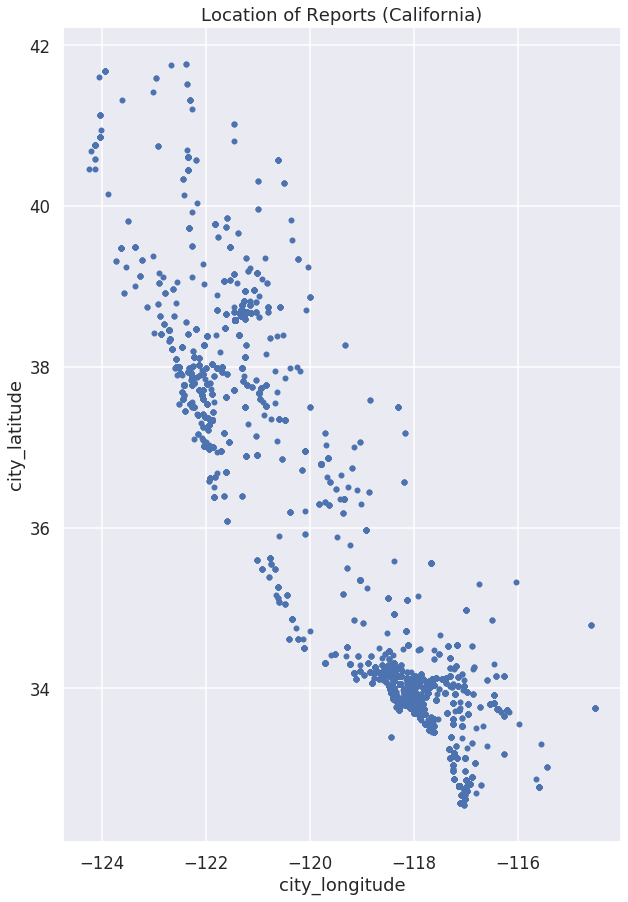

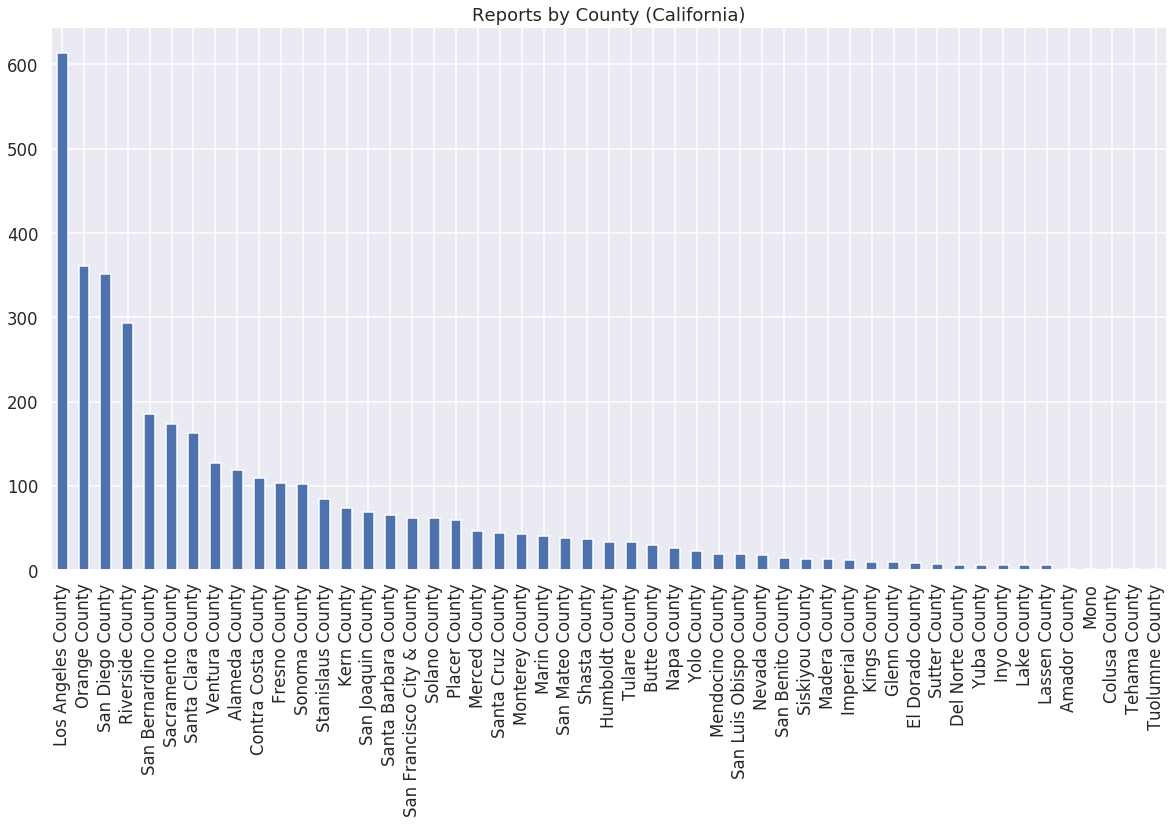

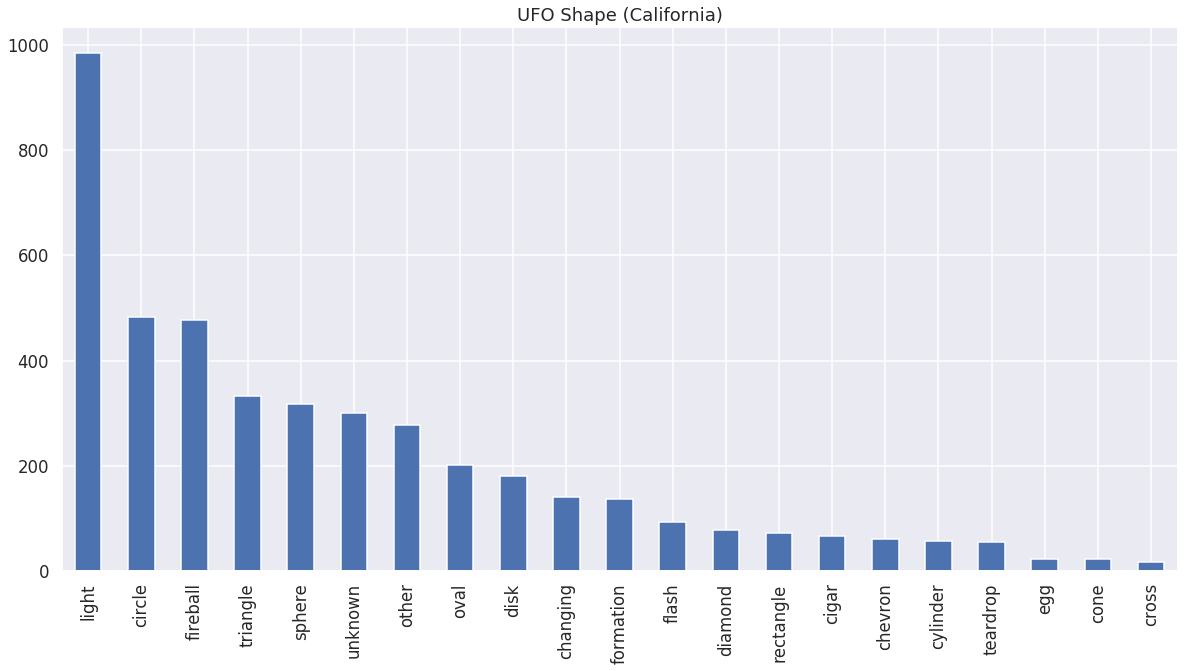

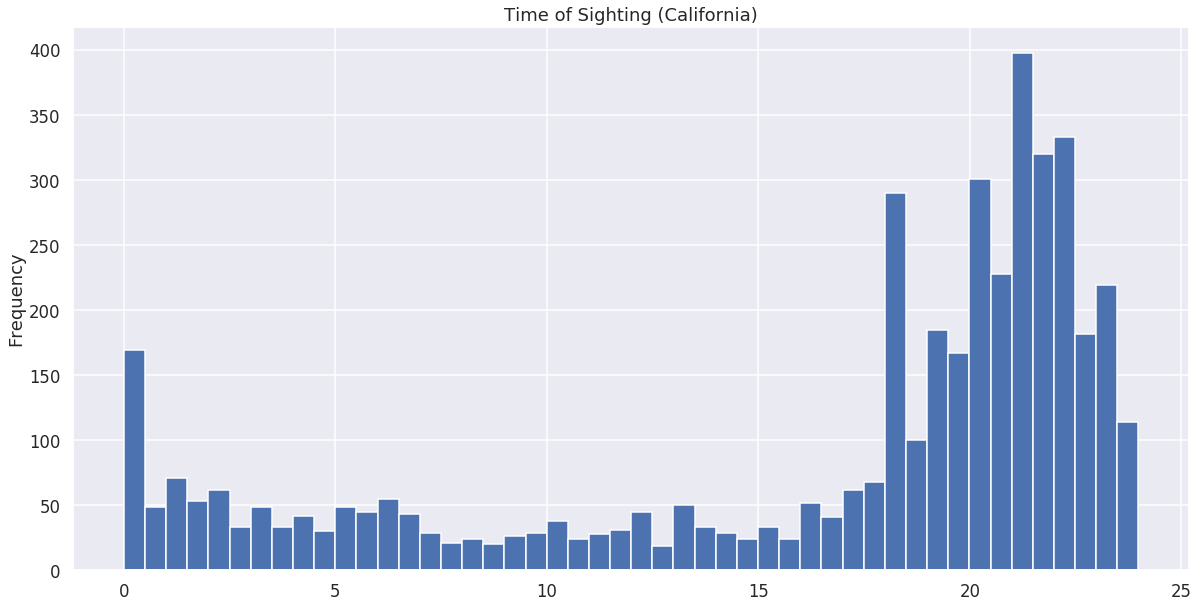

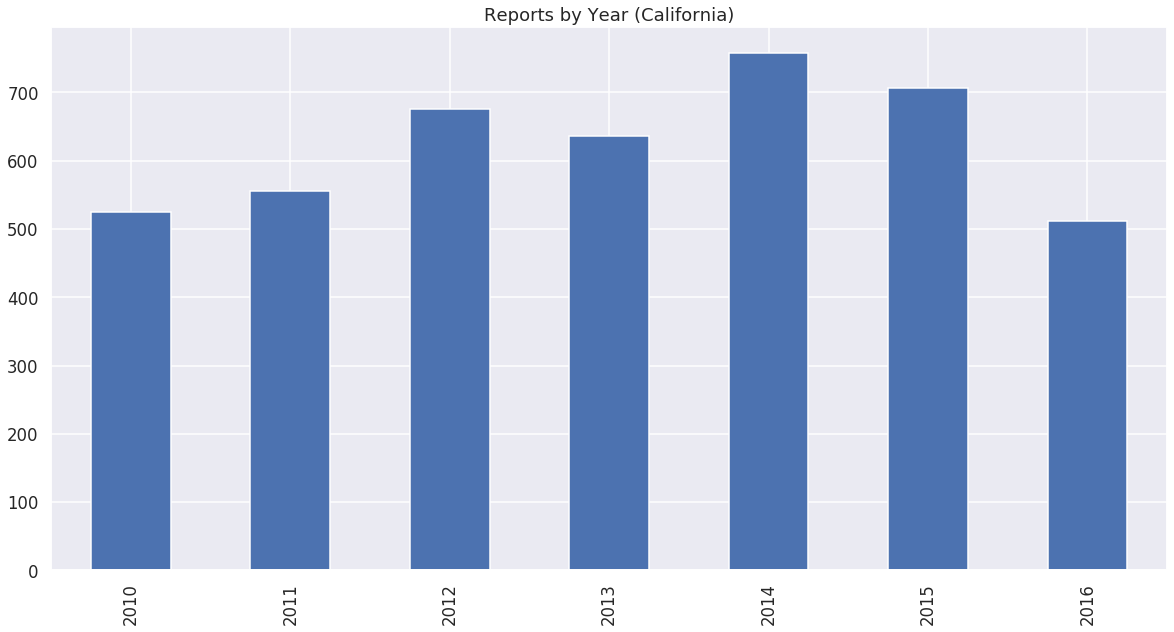

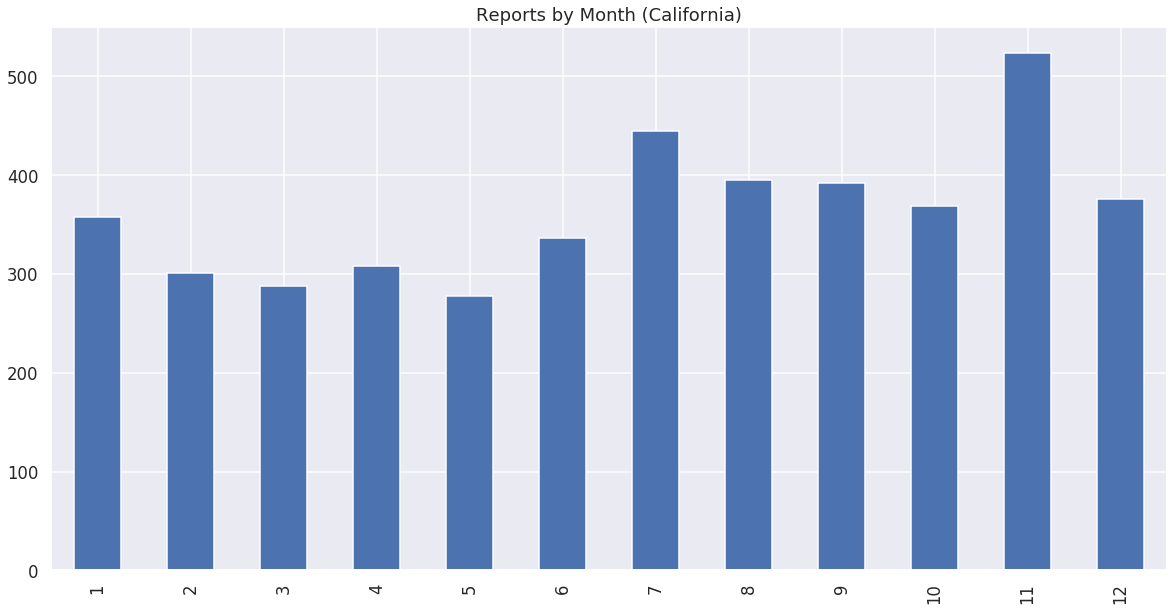

In [489]:
# Visualize California UFO Sightings

df_ca.plot(
    kind='scatter',
    x='city_longitude',
    y='city_latitude',
    figsize=(10,15),
    title='Location of Reports (California)'
);plt.show()

df_ca['county'].value_counts().plot(
    kind='bar',
    figsize=(20,10),
    title='Reports by County (California)'
);plt.show()

df_ca['shape'].value_counts().plot(
    kind='bar',
    figsize=(20,10),
    title='UFO Shape (California)'
);plt.show()

df_ca['time'].plot(
    kind='hist',
    bins=48,
    figsize=(20,10),
    title='Time of Sighting (California)'
);plt.show()

df_ca['year'].value_counts().sort_index().plot(
    kind='bar',
    sort_columns=True,
    figsize=(20,10),
    title='Reports by Year (California)'
);plt.show()

df_ca['month'].value_counts().sort_index().plot(
    kind='bar',
    sort_columns=True,
    figsize=(20,10),
    title='Reports by Month (California)'
);plt.show()


## Data Analysis

In [490]:
# get the pop estimate of a county from a year
def get_pop_estimate(row):
    r = df_pop.loc[df_pop['Area_Name']==row['county']]
    return r['POP_ESTIMATE_'+str(row['year'])].tolist()[0]

# get the number of ufo sightings from a county from a year
def get_sightings_num(row):
    sightings = df_ca[(df_ca['county']==row['county']) & (df_ca['year']==row['year'])]
    return sightings.shape[0]

def get_unemployment(row):
    r = df_ua.loc[df_ua['Area_name']==row['county']]
    return r['Unemployment_rate_'+str(row['year'])].tolist()[0]

def get_education(row):
    r = df_ed.loc[df_ed['Area name']==row['county']]
    return 100.0 - r['Percent of adults with less than a high school diploma, 2013-17'].tolist()[0]

In [491]:
# create analysis dataframe
df_anal = pd.DataFrame()
df_anal['county'] = ca_counties * len(year_range)
df_anal['year'] = list(itertools.chain.from_iterable([[year] * len(ca_counties) for year in year_range]))
df_anal['pop'] = df_anal.apply(get_pop_estimate,axis=1)
df_anal['sightings'] = df_anal.apply(get_sightings_num,axis=1)
df_anal['sightings per cap x 100,000'] = df_anal.apply(lambda row:(row['sightings'] / row['pop'])*100000,axis=1)
df_anal['unemployment'] = df_anal.apply(get_unemployment,axis=1)
df_anal['education'] = df_anal.apply(get_education,axis=1)
df_anal = df_anal[df_anal['sightings']!=0]
degrees_freedom = df_anal.shape[0] - 2
df_anal.head()

,county,year,pop,sightings,"sightings per cap x 100,000",unemployment,education
0,Alameda County,2010,1513043,17,1.12,10.9,87.5
2,Amador County,2010,37884,1,2.64,14.1,89.7
3,Butte County,2010,219945,2,0.91,13.9,88.8
5,Colusa County,2010,21437,1,4.66,20.8,69.4
6,Contra Costa County,2010,1052559,15,1.43,11.0,89.1


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


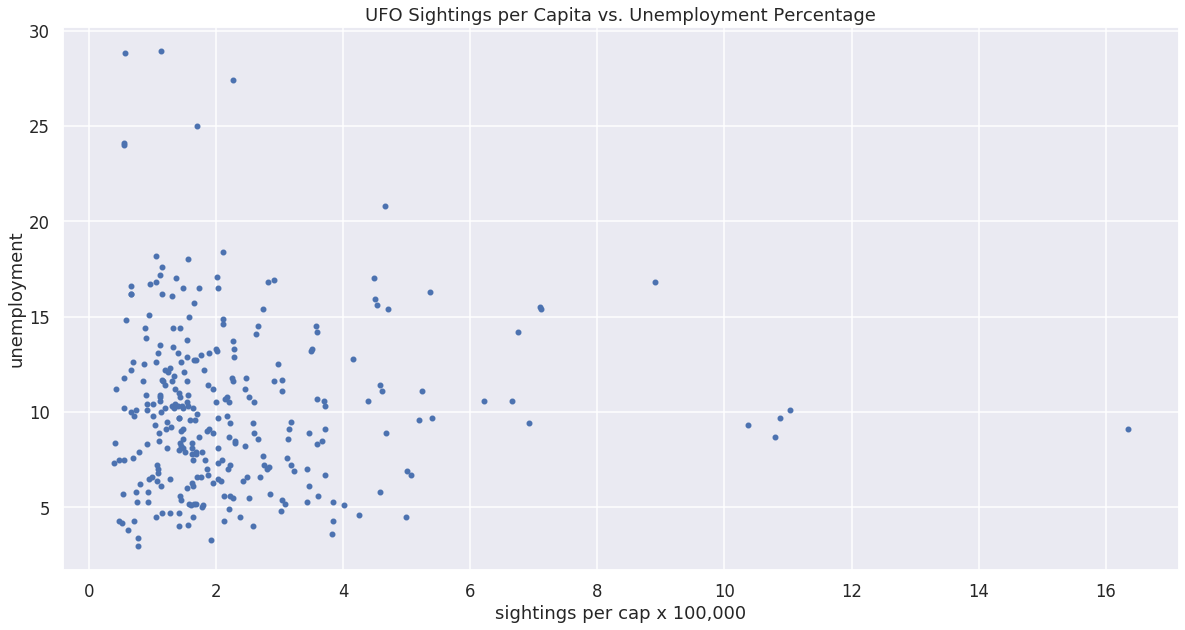

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


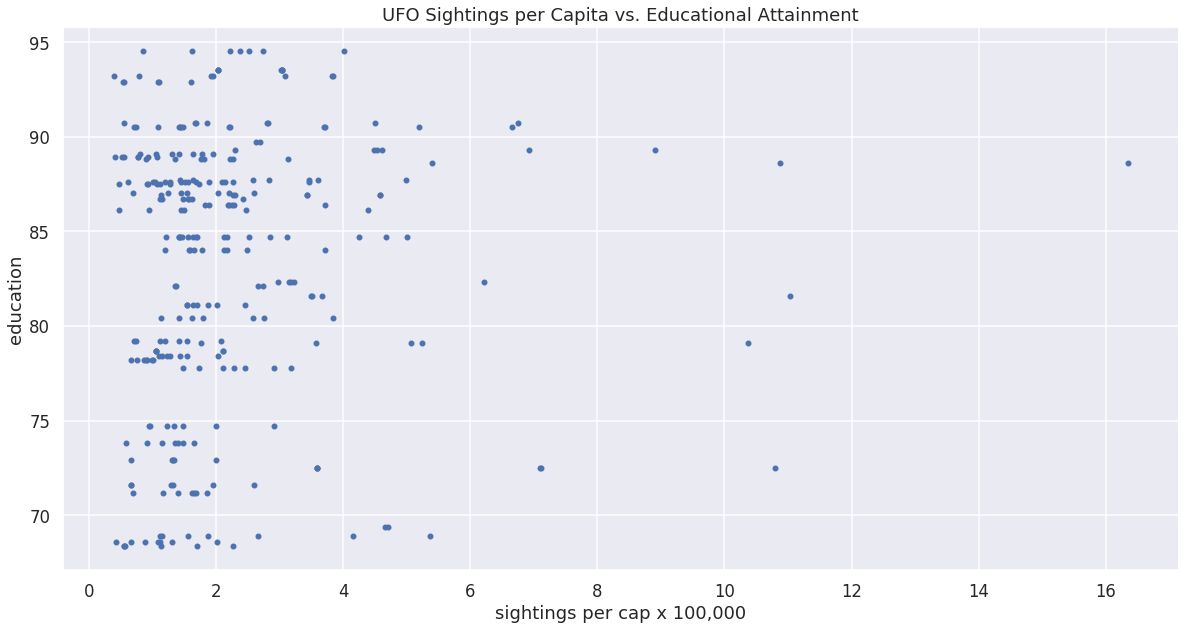

In [492]:
# plot relationships between UFO sightings per capita and uemployment / education
df_anal.plot(
    kind='scatter',
    x='sightings per cap x 100,000',
    y='unemployment',
    figsize=(20,10),
    title='UFO Sightings per Capita vs. Unemployment Percentage'
);plt.show()

df_anal.plot(
    kind='scatter',
    x='sightings per cap x 100,000',
    y='education',
    figsize=(20,10),
    title='UFO Sightings per Capita vs. Educational Attainment'
);plt.show()

y = 0.006769214959296644 * x + 10
r^2 = 8.625566597530998e-06
pearson correlation coefficient: 0.0029369314934846098


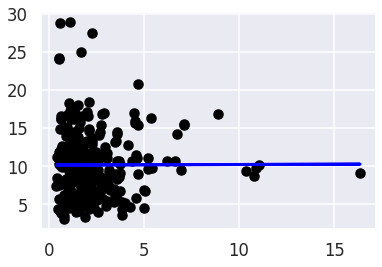

In [493]:
X = df_anal['sightings per cap x 100,000'].values.reshape(-1,1)
Y = df_anal['unemployment'].values
regr = linear_model.LinearRegression().fit(X,Y)
pred = regr.predict(X)

plt.scatter(X, Y,  color='black')
plt.plot(X, pred, color='blue', linewidth=3)

print("y = %s * x + %d" % (regr.coef_[0], regr.intercept_))
print("r^2 = " + str(r2_score(Y, pred)))
print("pearson correlation coefficient: " + str(df_anal['sightings per cap x 100,000'].corr(df_anal['unemployment'])))

y = 0.31168125256126417 * x + 82
r^2 = 0.006341076318498562
pearson correlation coefficient: 0.07963087540959714


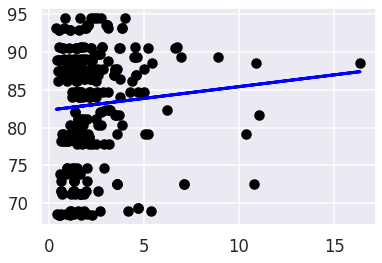

In [494]:
X = df_anal['sightings per cap x 100,000'].values.reshape(-1,1)
Y = df_anal['education'].values
regr = linear_model.LinearRegression().fit(X,Y)
pred = regr.predict(X)

plt.scatter(X, Y,  color='black')
plt.plot(X, pred, color='blue', linewidth=3)

print("y = %s * x + %d" % (regr.coef_[0], regr.intercept_))
print("r^2 = " + str(r2_score(Y, pred)))
print("pearson correlation coefficient: " + str(df_anal['sightings per cap x 100,000'].corr(df_anal['education'])))

## Results

### UFO Sighting Frequency and Unemployment - Fail to Reject Null Hypothesis

- n = 292. 
- df = 290
- r-critical = 0.115
- r-value = 0.0029369314934846098

### UFO Sighting Frequency and Educational Attainment - Fail to Reject Null Hypothesis

- n = 292. 
- df = 290
- r-critical = 0.115
- r-value = 0.07963087540959714


In the case of both tests, the resulting r value is less than the r critical for a two-tailed hypothesis with an alpha of 0.05. Therefore we fail to reject our null hypothesis for both cases. It appears that there is not a detectable correlation between ufo sighting frequency and either unemployment or educational attainment.

## Ethics and Privacy

For this project, there are minimal ethical considerations. UFO sightings are deemed trivial by society and
while interesting, probably are not of much importance. This project further does not deal with information regarding individual people or any personal information of any kind.

## Conclusion and Discussion